In [2]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import xgboost as xgb
import phik
import shap

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error


from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# Datasets & feature engeneering

In [3]:
df = pd.read_csv('data.csv')

In [4]:
df_position = pd.read_csv('meta.csv')

In [5]:
df_position["type"] = df_position["cat"].str[0]

In [6]:
df_position

,cat,x,y,type
0,P1,190,190,P
1,P2,190,890,P
2,I1,890,190,I
3,I2,590,770,I
4,I3,670,510,I


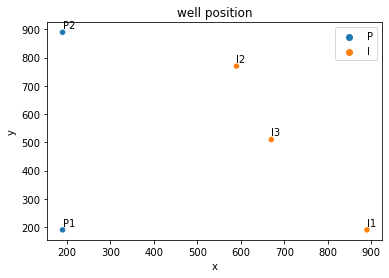

In [7]:
# make a scatterplot for each well
sns.scatterplot(data = df_position, x = 'x', y = 'y', hue = 'type')

for i in range(len(df_position)):
    plt.text(df_position['x'][i], df_position['y'][i] + 15, df_position['cat'][i])
    
plt.xlabel('x')
plt.ylabel('y')
plt.title('well position')
plt.legend()
plt.show()

In [8]:
df

,cat,group,date,oil,water,liquid,bhp,status,start_lag,coef,is_base
0,P1,P,0,-0.001621,0.000000,-0.001621,2.000000e+07,1.0,19.0,0.42,False
1,P2,P,0,-0.001903,0.000000,-0.001903,2.000000e+07,1.0,19.0,0.42,False
2,I1,I,0,NaN,0.002533,0.002533,4.018987e+07,1.0,19.0,0.42,False
3,I2,I,0,NaN,0.001267,0.001267,3.665494e+07,1.0,19.0,0.42,False
4,I3,I,0,NaN,NaN,NaN,NaN,0.0,19.0,0.42,False
...,...,...,...,...,...,...,...,...,...,...,...
28915,I2,I,28,0.000000,0.001267,0.001267,2.947955e+07,1.0,NaN,NaN,True
28916,P1,P,29,-0.000345,-0.001319,-0.001665,2.000000e+07,1.0,NaN,NaN,True
28917,P2,P,29,-0.000230,-0.001906,-0.002136,2.000000e+07,1.0,NaN,NaN,True
28918,I1,I,29,0.000000,0.002533,0.002533,3.281453e+07,1.0,NaN,NaN,True


In [9]:
# add coordinates for each well 
df = pd.merge(df, df_position, on = 'cat', how = 'left')

In [10]:
# remove duplicated type of well, rename coordinates
df = df.drop('type', axis = 1)
df = df.rename(columns = {'x': 'latitude',
                          'y': 'longitude'
                     })

In [11]:
# calculate destination between each wells and I3
df['destination_from_I3'] = round((((df['latitude'] - df.loc[df['cat'] == 'I3', 'latitude'].iloc[0])**2 +
                        (df['longitude'] - df.loc[df['cat'] == 'I3', 'longitude'].iloc[0])**2)**0.5), 0)

In [12]:
df

,cat,group,date,oil,water,liquid,bhp,status,start_lag,coef,is_base,latitude,longitude,destination_from_I3
0,P1,P,0,-0.001621,0.000000,-0.001621,2.000000e+07,1.0,19.0,0.42,False,190,190,577.0
1,P2,P,0,-0.001903,0.000000,-0.001903,2.000000e+07,1.0,19.0,0.42,False,190,890,612.0
2,I1,I,0,NaN,0.002533,0.002533,4.018987e+07,1.0,19.0,0.42,False,890,190,388.0
3,I2,I,0,NaN,0.001267,0.001267,3.665494e+07,1.0,19.0,0.42,False,590,770,272.0
4,I3,I,0,NaN,NaN,NaN,NaN,0.0,19.0,0.42,False,670,510,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28915,I2,I,28,0.000000,0.001267,0.001267,2.947955e+07,1.0,NaN,NaN,True,590,770,272.0
28916,P1,P,29,-0.000345,-0.001319,-0.001665,2.000000e+07,1.0,NaN,NaN,True,190,190,577.0
28917,P2,P,29,-0.000230,-0.001906,-0.002136,2.000000e+07,1.0,NaN,NaN,True,190,890,612.0
28918,I1,I,29,0.000000,0.002533,0.002533,3.281453e+07,1.0,NaN,NaN,True,890,190,388.0


In [13]:
# reshape 'status' from float to int, 'is_base' from boolean to int
df['status'] = df['status'].astype(int)
df['is_base'] = df['is_base'] * 1

if we look on dataframe, we'll see 30 moments of time for each of wells. 150 in sum for 1 modeling

In [14]:
# let's number each of the simulations
df['modeling_number'] = df.index // 150 + 1

In [15]:
# make dataframe with sum of oil for each wells for each simulation
df_p1_p2_sum_oil = df.pivot_table(values='oil', index='modeling_number', columns='cat', aggfunc='sum', fill_value=0)

In [16]:
df_p1_p2_sum_oil

cat,I1,I2,I3,P1,P2
modeling_number,,,,,
1,0,0,0,-0.029957,-0.025051
2,0,0,0,-0.029775,-0.024929
3,0,0,0,-0.030135,-0.025172
4,0,0,0,-0.030726,-0.025640
5,0,0,0,-0.030649,-0.025567
...,...,...,...,...,...
189,0,0,0,-0.029600,-0.024843
190,0,0,0,-0.029474,-0.024737
191,0,0,0,-0.029449,-0.024718


In [17]:
# merge df_p1_p2_sum_oil with original df
df = df.merge(df_p1_p2_sum_oil, left_on='modeling_number', right_index=True, how='left')

In [18]:
# let's rename
df = df.rename({'P1': 'P1_oil_sum',
                'P2': 'P2_oil_sum'
                }, axis = 1)

# and drop unnecessary
df = df.drop(['I1', 'I2', 'I3'], axis = 1)

In [19]:
# make the same for liquid
df_p1_p2_sum_liquid = df.pivot_table(values='liquid', index='modeling_number', columns='cat', aggfunc='sum', fill_value=0)

In [20]:
df_p1_p2_sum_liquid

cat,I1,I2,I3,P1,P2
modeling_number,,,,,
1,0.07599,0.03801,0.015960,-0.055689,-0.072974
2,0.07599,0.03801,0.012768,-0.054405,-0.071065
3,0.07599,0.03801,0.019152,-0.056961,-0.074895
4,0.07599,0.03801,0.030324,-0.061419,-0.081613
5,0.07599,0.03801,0.028728,-0.060784,-0.080651
...,...,...,...,...,...
189,0.07599,0.03801,0.008512,-0.052559,-0.068463
190,0.07599,0.03801,0.006992,-0.052120,-0.068014
191,0.07599,0.03801,0.006688,-0.051989,-0.067842


In [21]:
# merge df_p1_p2_sum_liquid with original df
df = df.merge(df_p1_p2_sum_liquid, left_on='modeling_number', right_index=True, how='left')

In [22]:
# let's rename
df = df.rename({'P1': 'P1_liquid_sum',
                'P2': 'P2_liquid_sum'
                }, axis = 1)

# and drop unnecessary
df = df.drop(['I1', 'I2', 'I3'], axis = 1)

in some cases, important not only total oil production, but relative content of oil in total production volume. So, let's make column with relative oil content.

In [23]:
df['P1_oil_relative'] = df['P1_oil_sum'] / df['P1_liquid_sum']
df['P2_oil_relative'] = df['P2_oil_sum'] / df['P2_liquid_sum']

In [24]:
df

,cat,group,date,oil,water,liquid,bhp,status,start_lag,coef,...,latitude,longitude,destination_from_I3,modeling_number,P1_oil_sum,P2_oil_sum,P1_liquid_sum,P2_liquid_sum,P1_oil_relative,P2_oil_relative
0,P1,P,0,-0.001621,0.000000,-0.001621,2.000000e+07,1,19.0,0.42,...,190,190,577.0,1,-0.029957,-0.025051,-0.055689,-0.072974,0.537922,0.343284
1,P2,P,0,-0.001903,0.000000,-0.001903,2.000000e+07,1,19.0,0.42,...,190,890,612.0,1,-0.029957,-0.025051,-0.055689,-0.072974,0.537922,0.343284
2,I1,I,0,NaN,0.002533,0.002533,4.018987e+07,1,19.0,0.42,...,890,190,388.0,1,-0.029957,-0.025051,-0.055689,-0.072974,0.537922,0.343284
3,I2,I,0,NaN,0.001267,0.001267,3.665494e+07,1,19.0,0.42,...,590,770,272.0,1,-0.029957,-0.025051,-0.055689,-0.072974,0.537922,0.343284
4,I3,I,0,NaN,NaN,NaN,NaN,0,19.0,0.42,...,670,510,0.0,1,-0.029957,-0.025051,-0.055689,-0.072974,0.537922,0.343284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28915,I2,I,28,0.000000,0.001267,0.001267,2.947955e+07,1,NaN,NaN,...,590,770,272.0,193,-0.028961,-0.024396,-0.049314,-0.063954,0.587269,0.381464
28916,P1,P,29,-0.000345,-0.001319,-0.001665,2.000000e+07,1,NaN,NaN,...,190,190,577.0,193,-0.028961,-0.024396,-0.049314,-0.063954,0.587269,0.381464
28917,P2,P,29,-0.000230,-0.001906,-0.002136,2.000000e+07,1,NaN,NaN,...,190,890,612.0,193,-0.028961,-0.024396,-0.049314,-0.063954,0.587269,0.381464
28918,I1,I,29,0.000000,0.002533,0.002533,3.281453e+07,1,NaN,NaN,...,890,190,388.0,193,-0.028961,-0.024396,-0.049314,-0.063954,0.587269,0.381464


# EDA

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28920 entries, 0 to 28919
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   cat                  28920 non-null  object 
 1   group                28920 non-null  object 
 2   date                 28920 non-null  int64  
 3   oil                  11640 non-null  float64
 4   water                26328 non-null  float64
 5   liquid               26328 non-null  float64
 6   bhp                  26328 non-null  float64
 7   status               28920 non-null  int32  
 8   start_lag            28800 non-null  float64
 9   coef                 28800 non-null  float64
 10  is_base              28920 non-null  int32  
 11  latitude             28920 non-null  int64  
 12  longitude            28920 non-null  int64  
 13  destination_from_I3  28920 non-null  float64
 14  modeling_number      28920 non-null  int64  
 15  P1_oil_sum           28920 non-null 

In [26]:
df.describe()

,date,oil,water,liquid,bhp,status,start_lag,coef,is_base,latitude,longitude,destination_from_I3,modeling_number,P1_oil_sum,P2_oil_sum,P1_liquid_sum,P2_liquid_sum,P1_oil_relative,P2_oil_relative
count,28920.000000,11640.000000,26328.000000,26328.000000,2.632800e+04,28920.000000,28800.000000,28800.000000,28920.000000,28920.000000,28920.000000,28920.000000,28920.000000,28920.000000,28920.000000,28920.000000,28920.000000,28920.000000,28920.000000
mean,14.500000,-0.000923,0.000419,0.000011,2.908081e+07,0.910373,12.500000,0.375000,0.004149,505.829876,510.000000,370.183610,96.900415,-0.030301,-0.025360,-0.058619,-0.077319,0.521441,0.331565
std,8.655591,0.000551,0.001771,0.002118,8.485229e+06,0.285651,6.922307,0.191511,0.064283,276.184320,288.876026,222.619338,55.657497,0.000795,0.000643,0.006473,0.009356,0.041110,0.029784
min,0.000000,-0.002532,-0.003347,-0.004083,2.000000e+07,0.000000,1.000000,0.080000,0.000000,190.000000,190.000000,0.000000,1.000000,-0.032422,-0.027377,-0.076260,-0.102243,0.424654,0.265512
25%,7.000000,-0.001502,-0.001180,-0.002047,2.000000e+07,1.000000,6.750000,0.230000,0.000000,190.000000,190.000000,272.000000,49.000000,-0.030883,-0.025751,-0.062552,-0.082977,0.492560,0.309001
50%,14.500000,-0.000737,0.001260,0.001260,3.159017e+07,1.000000,12.500000,0.375000,0.000000,590.000000,510.000000,388.000000,97.000000,-0.030160,-0.025229,-0.056961,-0.075023,0.529045,0.336097
75%,22.000000,-0.000435,0.001976,0.001976,3.666387e+07,1.000000,18.250000,0.520000,0.000000,670.000000,770.000000,577.000000,145.000000,-0.029623,-0.024842,-0.053315,-0.069531,0.555573,0.356975
max,29.000000,0.000000,0.002546,0.002546,4.950009e+07,1.000000,24.000000,0.670000,1.000000,890.000000,890.000000,612.000000,193.000000,-0.028961,-0.024396,-0.049314,-0.063954,0.587269,0.381464


In [27]:
df.isna().sum()

cat                        0
group                      0
date                       0
oil                    17280
water                   2592
liquid                  2592
bhp                     2592
status                     0
start_lag                120
coef                     120
is_base                    0
latitude                   0
longitude                  0
destination_from_I3        0
modeling_number            0
P1_oil_sum                 0
P2_oil_sum                 0
P1_liquid_sum              0
P2_liquid_sum              0
P1_oil_relative            0
P2_oil_relative            0
dtype: int64

<AxesSubplot:>

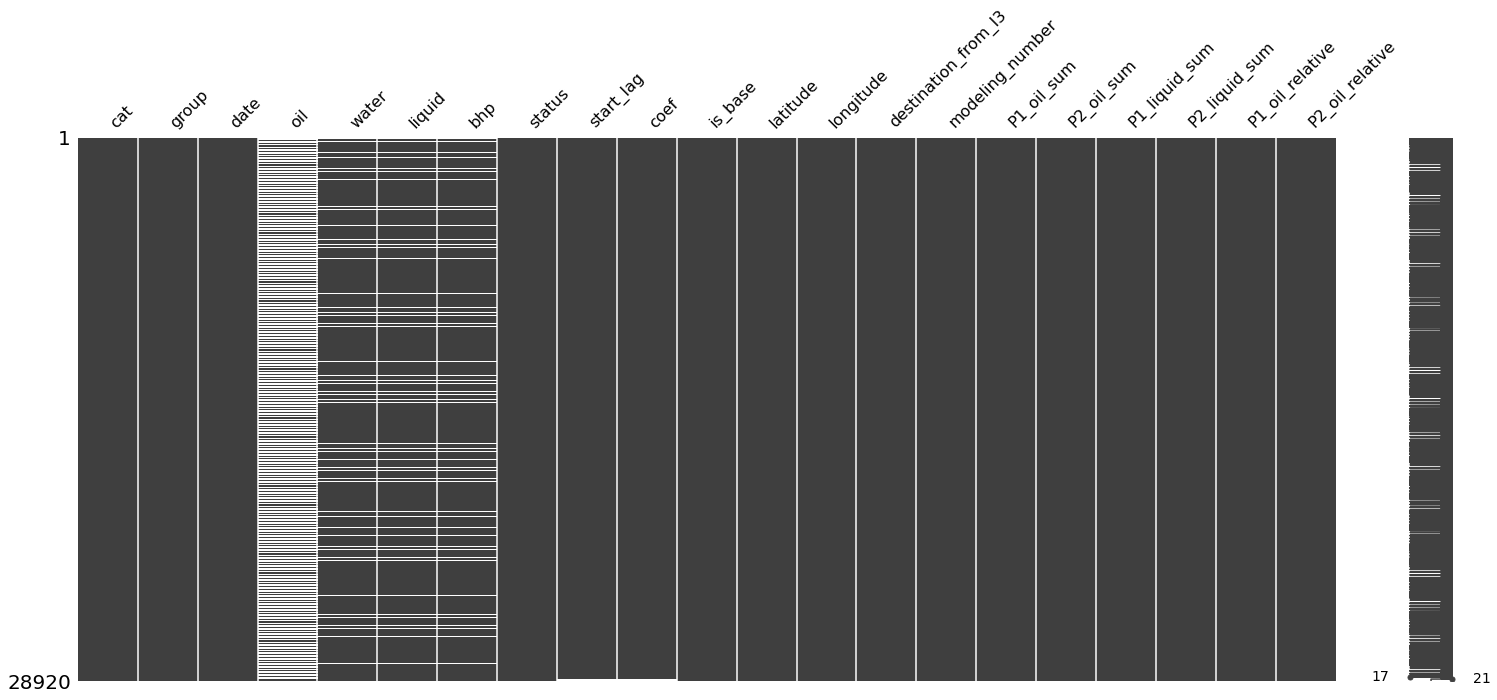

In [28]:
# let's see the distribution of missing values
msno.matrix(df)

In [29]:
# fill nan for case, when well is injector, that means it can't produce oil
# nan = 0
df.loc[(df['group'] == 'I') & (df['status'] == 1), 'oil'] = df['oil'].fillna(0)

In [30]:
# if status = 0, well not take part in modeling
# let's delete line for these cases
df = df[df['status'] != 0]

<AxesSubplot:>

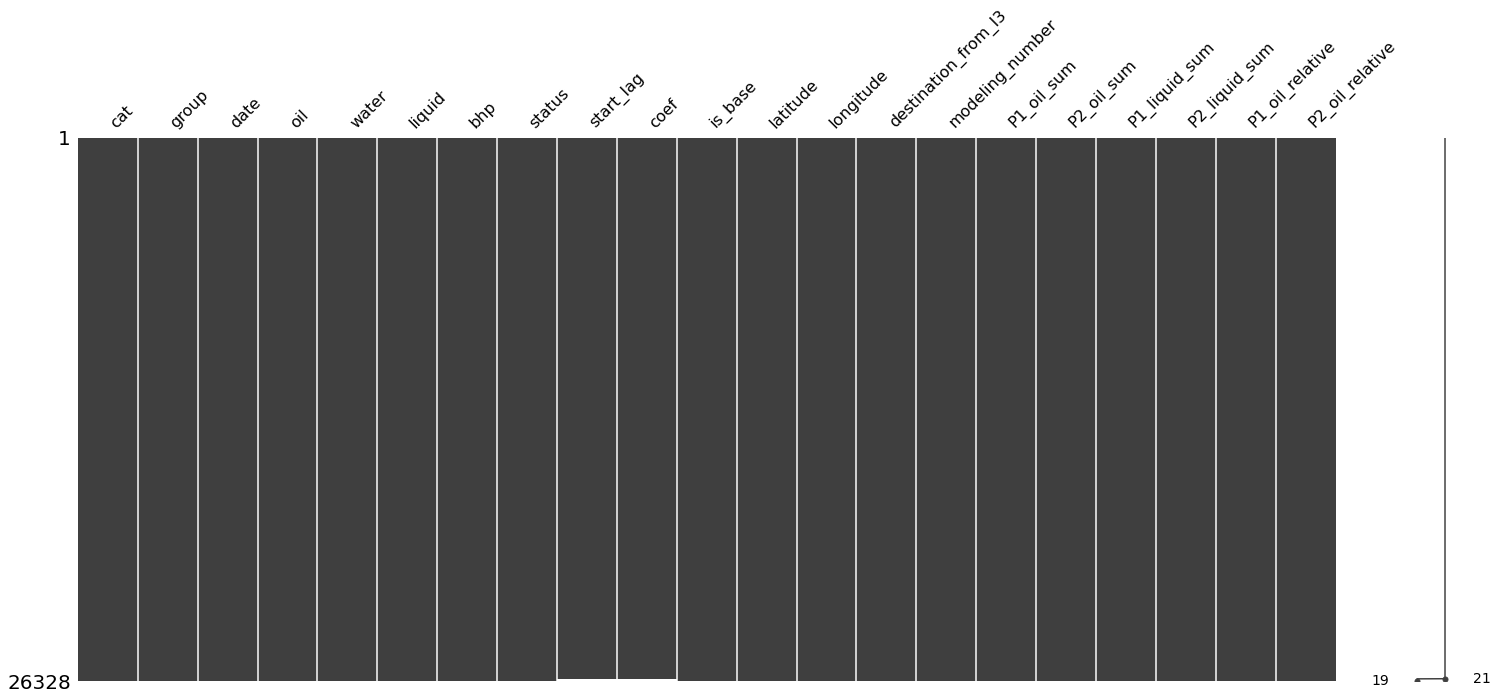

In [31]:
# if we look very carefully, we can see 120 nan in start_lag and coef in the end
msno.matrix(df)

In [32]:
# all cases when I3 not worked
df[df['is_base'] == 1]['is_base'].count()

120

In [33]:
# for base case, I3 not worked, so start_lag = 0
df.loc[df['is_base'] == 1, 'start_lag'] = 0

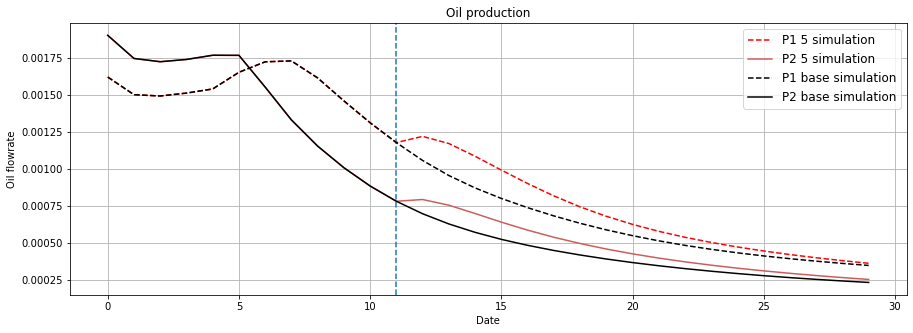

In [34]:
# here we chose number of simulation
n_modeling_number = 5

fig, ax = plt.subplots(figsize=(15, 5))

# make df for vizualization of simulation
filtered_df_p1 = df[(df['modeling_number'] == n_modeling_number) & (df['cat']== 'P1')]
filtered_df_p2 = df[(df['modeling_number'] == n_modeling_number) & (df['cat']== 'P2')]
plt.plot(filtered_df_p1['date'], np.abs(filtered_df_p1['oil']), color="r",linestyle = '--',  label = f'P1 {n_modeling_number} simulation')
plt.plot(filtered_df_p2['date'], np.abs(filtered_df_p2['oil']), color="#CD5C5C", label = f'P2 {n_modeling_number} simulation')

# make vertical line with start lag
start_lag_value = df.loc[df['modeling_number'] == n_modeling_number, 'start_lag'].iloc[0]
plt.axvline(x = start_lag_value, linestyle='--')

# make df for vizualization of base simulation
filtered_df_base_p1 = df[(df['is_base'] == 1) & (df['cat']== 'P1')]
filtered_df_base_p2 = df[(df['is_base'] == 1) & (df['cat']== 'P2')]
plt.plot(filtered_df_base_p1['date'], np.abs(filtered_df_base_p1['oil']), color="k", linestyle = '--', label = f'P1 base simulation')
plt.plot(filtered_df_base_p2['date'], np.abs(filtered_df_base_p2['oil']), color="k", label = f'P2 base simulation')

plt.legend(loc="upper right", fontsize='large')
plt.title('Oil production')
plt.xlabel('Date')
plt.ylabel('Oil flowrate')
plt.grid(True)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

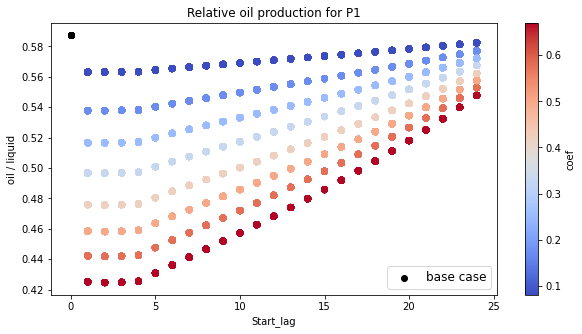

In [35]:
fig = plt.subplots(figsize = (10, 5))

# make scatter for relative oil production for P1
plt.scatter(df['start_lag'], df['P1_oil_relative'], c = df['coef'], cmap='coolwarm')
cbar = plt.colorbar()
cbar.set_label('coef')

# make dot for base case
plt.scatter(df[df['is_base'] == 1]['start_lag'], df[df['is_base'] == 1]['P1_oil_relative'], color = 'k', label = 'base case')

plt.legend(loc = "lower right", fontsize = 'large')
plt.title('Relative oil production for P1')
plt.xlabel('Start_lag')
plt.ylabel('oil / liquid')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

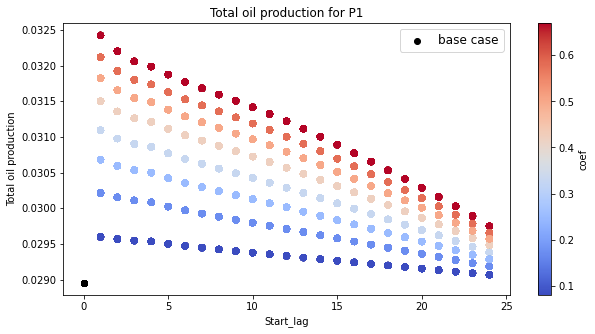

In [36]:
fig = plt.subplots(figsize = (10, 5))

# make scatter for oil production for P1
plt.scatter(df['start_lag'], np.abs(df['P1_oil_sum']), c = df['coef'], cmap='coolwarm')
cbar = plt.colorbar()
cbar.set_label('coef')

# make dot for base case
plt.scatter(df[df['is_base'] == 1]['start_lag'], np.abs(df[df['is_base'] == 1]['P1_oil_sum']), color = 'k', label = 'base case')


plt.legend(loc="upper right", fontsize = 'large')
plt.title('Total oil production for P1')
plt.xlabel('Start_lag')
plt.ylabel('Total oil production')
plt.show

## Conclusion 1

As we can see, for total oil production better to make max coef and start lag for I3 as early as possible. BUT for relative oil production (oil/liquid) better choose to start lag for I3 lately. For base case relative oil production is max (but minimum for absolutely value). It is necessary to know the normalized value for oil/liquid ratio, from this we can choose coef and start lag. 

Taking into account absolute and relative oil production - it'll be better to start lag when well depletion start. For our case, this corresponds after 5 lag.

And it necessary to add, that handling and processing larger volumes of non-oil fluids can incur higher production costs. Additional equipment and infrastructure may be required to separate and treat the fluids before they can be further processed or disposed of.

Below is a visualization for P2

<function matplotlib.pyplot.show(close=None, block=None)>

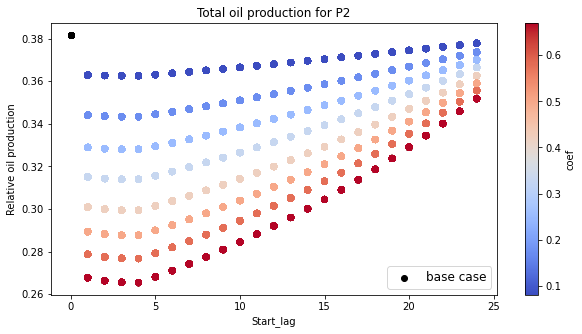

In [37]:
fig = plt.subplots(figsize = (10, 5))

# make scatter for relative oil production for P2
plt.scatter(df['start_lag'], df['P2_oil_relative'], c = df['coef'], cmap='coolwarm')
cbar = plt.colorbar()
cbar.set_label('coef')

# make dot for base case
plt.scatter(df[df['is_base'] == 1]['start_lag'], df[df['is_base'] == 1]['P2_oil_relative'], color = 'k', label = 'base case')

plt.legend(loc = "lower right", fontsize = 'large')
plt.title('Total oil production for P2')
plt.xlabel('Start_lag')
plt.ylabel('Relative oil production')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

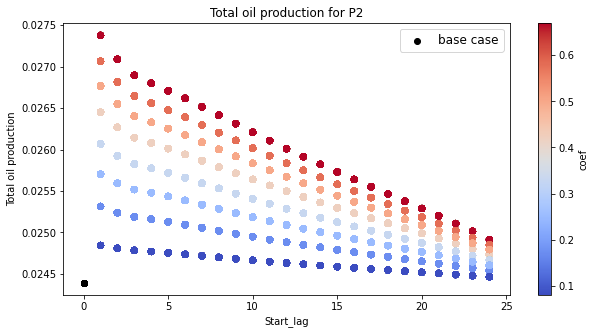

In [38]:
fig = plt.subplots(figsize = (10, 5))

# make scatter for oil production for P2
plt.scatter(df['start_lag'], np.abs(df['P2_oil_sum']), c = df['coef'], cmap='coolwarm')
cbar = plt.colorbar()
cbar.set_label('coef')

# make dot for base case
plt.scatter(df[df['is_base'] == 1]['start_lag'], np.abs(df[df['is_base'] == 1]['P2_oil_sum']), color = 'k', label = 'base case')


plt.legend(loc="upper right", fontsize = 'large')
plt.title('Total oil production for P2')
plt.xlabel('Start_lag')
plt.ylabel('Total oil production')
plt.show

The distributions for P1, P2 have a similar look.

<AxesSubplot:>

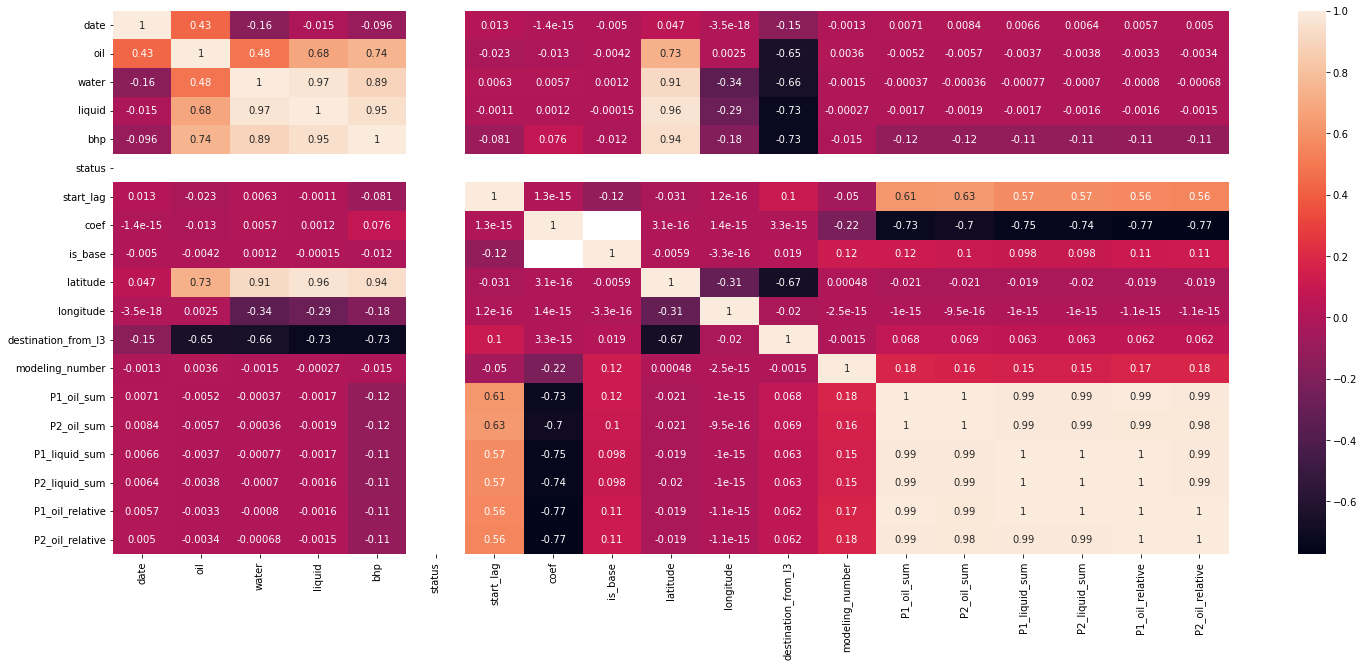

In [39]:
# let's see correlation in two ways
plt.figure(figsize=(25,10))
corr = df.corr()
sns.heatmap(corr, annot=True)

interval columns not set, guessing: ['date', 'oil', 'water', 'liquid', 'bhp', 'status', 'start_lag', 'coef', 'is_base', 'latitude', 'longitude', 'destination_from_I3', 'modeling_number', 'P1_oil_sum', 'P2_oil_sum', 'P1_liquid_sum', 'P2_liquid_sum', 'P1_oil_relative', 'P2_oil_relative']


Not enough unique value for variable status for analysis 1. Dropping this column


<AxesSubplot:>

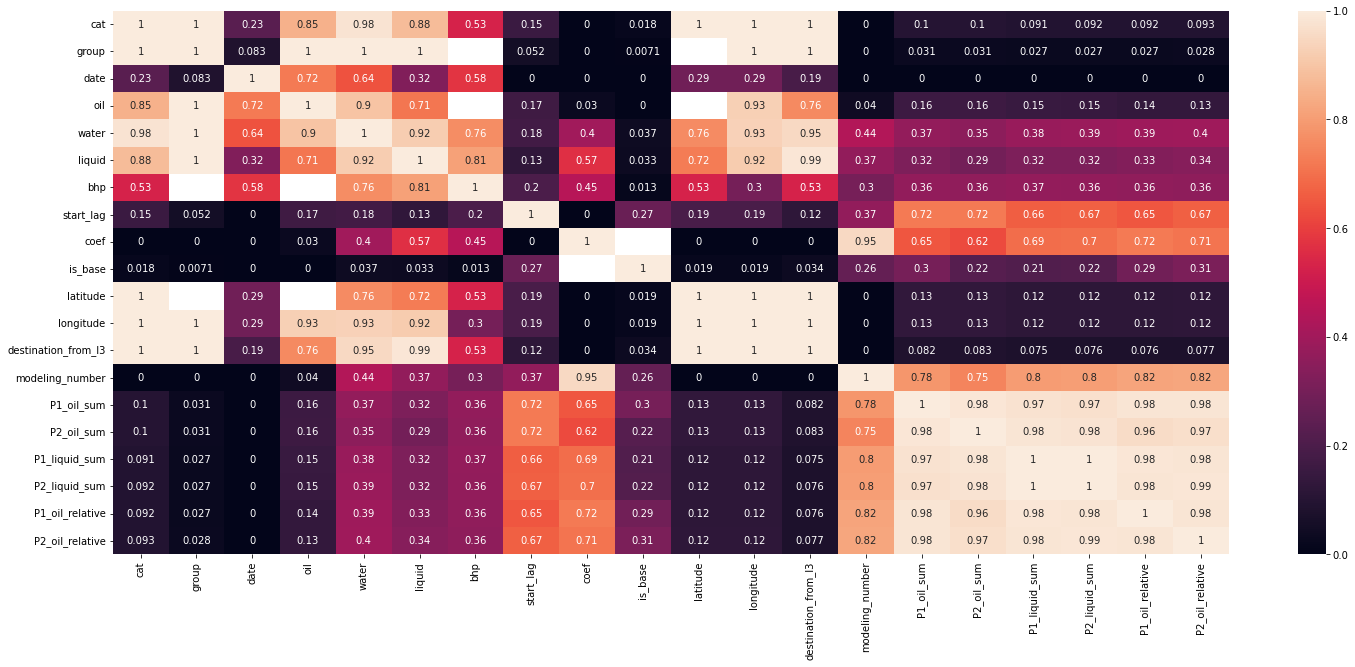

In [40]:
# The phik is suitable for calculating correlation in categorical variables and is sensitive to nonlinear dependencies
plt.figure(figsize=(25,10))
corr1 = df.phik_matrix()
sns.heatmap(corr1, annot=True)

Correlation in two ways approval suggestion about link between coef & start lag and relative_oil & absolute_oil

# Modelling

In [41]:
# let's see all dates
df['date'].agg([min, max])

min     0
max    29
Name: date, dtype: int64

We still have nan, so let's drop them

In [42]:
df = df.dropna(axis = 0)

In [43]:
# cat and group are categorial variables, so we must OHE them
df = pd.get_dummies(data = df, columns = ['cat', 'group'])

In [44]:
df.columns

Index(['date', 'oil', 'water', 'liquid', 'bhp', 'status', 'start_lag', 'coef',
       'is_base', 'latitude', 'longitude', 'destination_from_I3',
       'modeling_number', 'P1_oil_sum', 'P2_oil_sum', 'P1_liquid_sum',
       'P2_liquid_sum', 'P1_oil_relative', 'P2_oil_relative', 'cat_I1',
       'cat_I2', 'cat_I3', 'cat_P1', 'cat_P2', 'group_I', 'group_P'],
      dtype='object')

In [45]:
# make train/test split. We have 30 dates, so let's make 1/3 for the test
test = df.loc[df['date'] >= 20]
train = df.loc[df['date'] < 20]

In [46]:
# as 'y' I'll chose a oil
# you can chose liquid

# liquid is sum of oil and water, we can't use it, it'll broke the model
# the same applies, if we chose as target 'liquid'
# columns group and cat means the same, so left only cat
# columns P1_oil_sum, P1_oil_relative and so on, may have negative effect on prediction
# coordinates have strong correlation with group, so drop them
# 'status' permanent, drop this
# modeling number is not necessary
X = ['date', 'water', 'bhp', 'start_lag', 'coef',
       'destination_from_I3','cat_I1', 'cat_I2',
       'cat_I3', 'cat_P1', 'cat_P2'
       ]

y = ['oil']

In [47]:
X_train = train[X]
y_train = train[y]

X_test = test[X]
y_test = test[y]

In [48]:
model = xgb.XGBRegressor(n_estimators = 1000)

In [49]:
model.fit(X_train, y_train,
          eval_set = [(X_train, y_train), (X_test, y_test)],
          early_stopping_rounds = 50,
          verbose = False,
          )

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [50]:
y_pred_model = model.predict(X_train)

In [51]:
print(mean_absolute_error(y_pred_model, y_train))

7.243781611567546e-05


In [52]:
# let's use shap to vizualize feature importance
explainer = shap.Explainer(model)

In [53]:
shap_values = explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


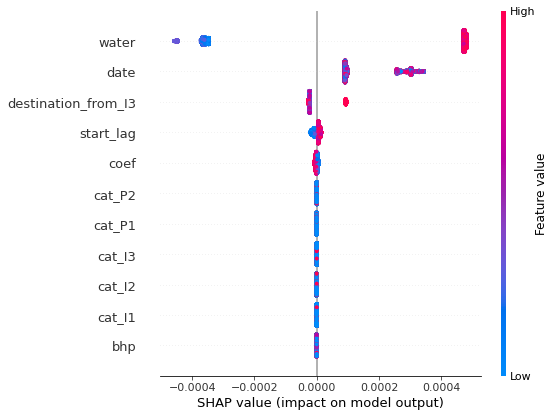

In [54]:
shap.summary_plot(shap_values, X_test)

In [55]:
feature_importance = pd.DataFrame(data = model.feature_importances_,
                                  index = model.feature_names_in_,
                                  columns = ['importance']
                                  )

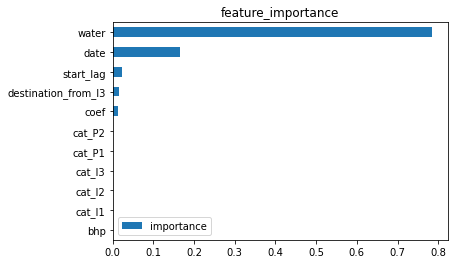

In [56]:
feature_importance.sort_values('importance').plot(kind = 'barh', title = 'feature_importance')
plt.show()

In [57]:
feature_importance.sort_values('importance', ascending = False)

,importance
water,0.783657
date,0.165993
start_lag,0.023726
destination_from_I3,0.014271
coef,0.012353
bhp,0.000000
cat_I1,0.000000
cat_I2,0.000000
cat_I3,0.000000
cat_P1,0.000000


## Conclusion 2

feature_importance show us, that most valuable feature is water (not surprised - more water from I3, more oil). On the second plase is date - this is because of gradual depletion of a well (more time - less oil).

In [58]:
# if we want maximum interpreted model, we should chose linear regression model

model_linear = Ridge()
model_linear.fit(X_train, y_train)
y_pred_ridge = model_linear.predict(X_train)

Ill-conditioned matrix (rcond=4.58817e-19): result may not be accurate.


In [59]:
# linear regression less accurate, then xgb
print(mean_absolute_error(y_pred_ridge, y_train))

0.00018683057789000944


In [60]:
# let's extract coefficients and intercept from linear regression
coefficients = model_linear.coef_
intercept = model_linear.intercept_

coefficients = coefficients.flatten( )

In [61]:
# make analytic formula for model
formula = f'y = {intercept}'
for i, coef in enumerate(coefficients):
    formula += f' + {coef}*x{i+1}'
print(formula)

y = [-0.00288375] + 4.456352026945228e-05*x1 + -0.001434174057667043*x2 + 6.39261536019607e-11*x3 + 6.4582365049358966e-06*x4 + -0.00020540974664824192*x5 + -1.0636172579183377e-08*x6 + -8.407925011961106e-05*x7 + 0.00015801912117930787*x8 + -5.14411911354274e-05*x9 + -9.744941627077171e-05*x10 + 7.49507363275478e-05*x11


In [62]:
# x1 corresponds to date, x2 to water and so on
df_coefficients = pd.DataFrame({'feature': X, 'coefficient': coefficients})
df_coefficients

,feature,coefficient
0,date,4.456352e-05
1,water,-1.434174e-03
2,bhp,6.392615e-11
3,start_lag,6.458237e-06
4,coef,-2.054097e-04
5,destination_from_I3,-1.063617e-08
6,cat_I1,-8.407925e-05
7,cat_I2,1.580191e-04
8,cat_I3,-5.144119e-05
9,cat_P1,-9.744942e-05


In [63]:
# let's sort on importance
df_coefficients.sort_values('coefficient', ascending = True)

,feature,coefficient
1,water,-1.434174e-03
4,coef,-2.054097e-04
9,cat_P1,-9.744942e-05
6,cat_I1,-8.407925e-05
8,cat_I3,-5.144119e-05
5,destination_from_I3,-1.063617e-08
2,bhp,6.392615e-11
3,start_lag,6.458237e-06
0,date,4.456352e-05
10,cat_P2,7.495074e-05


We should to remember, that extract oil corresponds sign '-', therefore if coefficient is negative, then it affects on oil production more. The linear regression method allows us to use an analytical formula to predict oil production.

# Summary 

In this work I compared baseline with following simulation of injector well 3. Correspond to the conclusion 1, early start lag and max coef allow to extract more oil in absolute volume, but ratio oil/liquid (which also important), max in baseline. Knowing the norms for this ratio, we can extract more oil, avoiding negative impacts on infrastructure. As for the model, using standard for oil/liquid ratio, we can calculate this ratio for every moment of time and drop unsatisfactory to us start_lags, chose coef, and extract as more oil as possible.